# Recommendation System Project: IBM Community

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/3325/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t


df = pd.read_csv(
    'data/user-item-interactions.csv', 
    dtype={'article_id': int, 'title': str, 'email': str}
)

# Show df to get an idea of the data
df.head()

,Unnamed: 0,article_id,title,email
0,0,1430,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1,1314,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,2,1429,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,3,1338,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,4,1276,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` Are there any missing values? If so, provide a count of missing values. If there are missing values in `email`, assign it the same id value `"unknown_user"`.

In [4]:
# Some interactions do not have a user associated with it, assume the same user.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  45993 non-null  int64 
 1   article_id  45993 non-null  int64 
 2   title       45993 non-null  object
 3   email       45976 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.4+ MB


In [5]:
print(f"Number of Null email values is: ")
print(df.email.isna().sum())

Number of Null email values is: 
17


In [6]:
df[df.email.isna()]

,Unnamed: 0,article_id,title,email
25131,25146,1016,why you should master r (even if it might even...,NaN
29758,30157,1393,the nurse assignment problem,NaN
29759,30158,20,working interactively with rstudio and noteboo...,NaN
29760,30159,1174,breast cancer wisconsin (diagnostic) data set,NaN
29761,30160,62,data visualization: the importance of excludin...,NaN
35264,36016,224,"using apply, sapply, lapply in r",NaN
35276,36029,961,beyond parallelize and collect,NaN
35277,36030,268,sector correlations shiny app,NaN
35278,36031,268,sector correlations shiny app,NaN
35279,36032,268,sector correlations shiny app,NaN


In [7]:
# Fill email NaNs with "unknown_user"
df['email'] = df['email'].fillna('unknown_user')

In [8]:
# Check if no more NaNs 
df[df.email.isna()]

,Unnamed: 0,article_id,title,email


`2.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.

In [10]:
# What are the descriptive statistics of the number of articles a user interacts with?
articles_per_user = df.groupby('email')['article_id'].count()
articles_per_user.describe()


count    5149.000000
mean        8.932414
std        16.801011
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

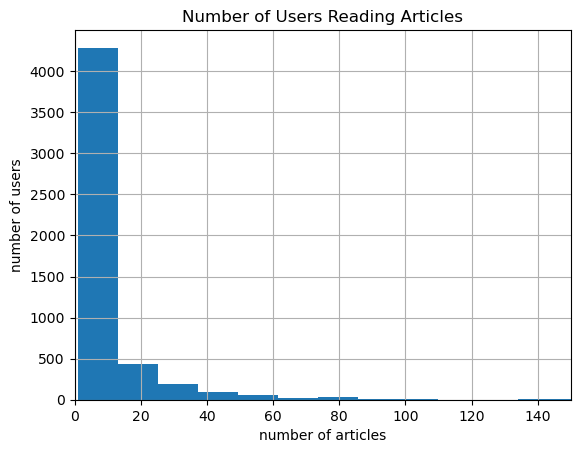

In [11]:
# Create a plot of the number of articles read by each user
articles_per_user.hist(bins=30)
plt.xlim(0, 150)

plt.xlabel('number of articles')
plt.ylabel('number of users')
plt.title('Number of Users Reading Articles')
plt.show()

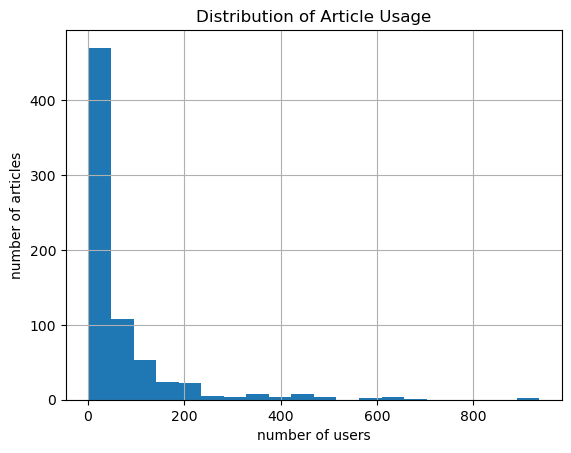

In [12]:
# Create a plot of the number of times each article was read
# Count how many users read each article
reads_per_article = df['article_id'].value_counts()
# Plot distribution
reads_per_article.hist(bins=20)

plt.xlabel('number of users')
plt.ylabel('number of articles')
plt.title('Distribution of Article Usage')
plt.show()

In [13]:
# Fill in the median and maximum number of user_article interactions below

median_val = articles_per_user.median()  # 50% of individuals interact with median_val number of articles or fewer.
max_views_by_user = articles_per_user.max()  # The maximum number of user-article interactions by any 1 user is max_views_by_user.

print(f"Median articles each user: {median_val}")
print(f"Maximum articles read by each user: {max_views_by_user}")


Median articles each user: 3.0
Maximum articles read by each user: 364


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [15]:
# The number of unique articles that have at least one interaction
unique_articles = df['article_id'].nunique()
# The number of unique articles on the IBM platform (since we only have interaction data, use same count)
total_articles = df['article_id'].nunique()
# The number of unique users
unique_users = df['email'].nunique()
# The number of user-article interactions
user_article_interactions =  df['article_id'].count()

print(f"Unique articles: {unique_articles}")
print(f"Total articles: {total_articles}")
print(f"Unique users: {unique_users}")
print(f"User-article interactions: {user_article_interactions}")



Unique articles: 714
Total articles: 714
Unique users: 5149
User-article interactions: 45993


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [17]:
most_viewed_article_id = df['article_id'].value_counts().idxmax()  # The most viewed article in the dataset as a string with one value following the decimal
max_views = df['article_id'].value_counts().max()  # The most viewed article in the dataset was viewed how many times?

In [18]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper(df=df):
    coded_dict = {
        email: num 
        for num, email in enumerate(df['email'].unique(), start=1)
    }
    return [coded_dict[val] for val in df['email']]

df['user_id'] = email_mapper(df)
del df['email']

# show header
df.head()

,Unnamed: 0,article_id,title,user_id
0,0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1,1314,healthcare python streaming application demo,2
2,2,1429,use deep learning for image classification,3
3,3,1338,ml optimization using cognitive assistant,4
4,4,1276,deploy your python model as a restful api,5


In [19]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

In this project, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article. In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [21]:
def get_top_articles(n, df=df):
    """
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    """
    top_article_ids = get_top_article_ids(n, df)
    
    top_articles = df[df['article_id'].astype(str).isin(top_article_ids)]['title'].unique().tolist()
    
    return top_articles # Return the top article titles from df

def get_top_article_ids(n, df=df):
    """
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    """
def get_top_article_ids(n, df=df):
    top_article_ids = (
        df['article_id']
        .value_counts()
        .head(n)
        .index
        .astype(str)
        .tolist()
    )
 
    return top_article_ids # Return the top article ids

In [22]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['healthcare python streaming application demo', 'use deep learning for image classification', 'apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'finding optimal locations of new store using decision optimization']
['1429', '1330', '1431', '1427', '1364', '1314', '1293', '1170', '1162', '1304']


In [23]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [25]:
def create_user_item_matrix(df, fill_value=0):
    """
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user-item matrix (users = rows, articles = columns)
    """
    user_item = df.groupby(['user_id', 'article_id']).size().unstack(fill_value=fill_value)
    user_item[user_item > 0] = 1
    return user_item # user_item matrix 

user_item = create_user_item_matrix(df)
user_item.head()

article_id,0,2,4,8,9,12,14,15,16,18,...,1434,1435,1436,1437,1439,1440,1441,1442,1443,1444
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [28]:
# Lets use the cosine_similarity function from sklearn
from sklearn.metrics.pairwise import cosine_similarity

In [29]:
def find_similar_users(user_id, user_item=user_item, include_similarity=False):
    """
    Finds similar users based on cosine similarity.
    
    INPUT:
      user_id             — (int) target user ID
      user_item           — (pd.DataFrame) user–article interaction matrix
      include_similarity  — (bool) if True, include similarity scores
    
    OUTPUT:
      similar_users — (list)
        if include_similarity=False: [user_id, ...] sorted by closeness
        if include_similarity=True:  [[user_id, score], ...]
    """
    # First, grab this user’s row from the matrix and turn it into a 1×N vector.
    user_vector = user_item.loc[user_id].values.reshape(1, -1)
    
    # And now we compute cosine similarity between that vector and every other user.
    raw_sims = cosine_similarity(user_item, user_vector).flatten()
    
    # Next, wrap those raw scores into a pandas Series so each score is keyed by user ID.
    similarities = pd.Series(raw_sims, index=user_item.index)
    
    # Then drop the entry for our target user (we don’t want to compare them to themselves),
    # and sort everyone else from most-to-least similar.
    similarities = similarities.drop(user_id).sort_values(ascending=False)
    
    # Finally, decide what format to return.
    # If the caller asked for similarity scores, pair each user ID with its score.
    if include_similarity:
        return [[other_id, score] for other_id, score in similarities.items()]
    # Otherwise just hand back the ordered list of user IDs.
    else:
        return similarities.index.tolist()


In [30]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 4201, 46, 824, 5034, 253, 5041, 136, 2305, 395]
The 5 most similar users to user 3933 are: [1, 46, 4201, 824, 5034]
The 3 most similar users to user 46 are: [4201, 790, 5077]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [32]:
def get_article_names(article_ids, df=df):
    """
    Retrieves article names corresponding to given article IDs.
    """
    # First up, we filter the DataFrame to just the rows matching our list of IDs.
    subset_df = df[df['article_id'].isin(article_ids)]
    # Then we group by article_id so we only pick one title per article.
    # It’s a handy way to collapse any duplicates if they exist.
    grouped = subset_df.groupby('article_id').first()
    # Now we grab the title column and turn it into a plain Python list.
    name_list = grouped['title'].tolist()
    
    # And that’s it—we hand back only the titles you asked for.
    return name_list


def get_ranked_article_unique_counts(article_ids, user_item=user_item):
    """
    Returns a sorted list of [article_id, unique_reader_count].
    """
    # We’ll build a simple dict mapping article → how many users read it.
    unique_counts = {}
    for art_id in article_ids:
        if art_id in user_item.columns:
            # Sum across the column gives total reads; cast to int so it’s not numpy-type.
            unique_counts[art_id] = int(user_item[art_id].sum())
        else:
            # If that ID isn’t even in our matrix, we just say zero readers.
            unique_counts[art_id] = 0

    # Next we sort those (article, count) pairs by count descending.
    sorted_counts = sorted(unique_counts.items(), key=lambda pair: pair[1], reverse=True)
    # And turn each tuple into a two-element list, because that’s what Udacity expects.
    ranked_list = [[art, cnt] for art, cnt in sorted_counts]
    
    # Return the list of [article_id, count], highest counts first.
    return ranked_list


def get_user_articles(user_id, user_item=user_item):
    """
    Retrieves the list of article IDs and corresponding article names that a user has interacted with.
    """
    # Grab all the columns (article IDs) where this user has a '1'—meaning they read it.
    seen_ids = user_item.columns[user_item.loc[user_id] == 1].tolist()
    # Then call our helper to fetch the actual titles for those IDs.
    seen_titles = get_article_names(seen_ids, df=df)
    
    # We hand back two things: the list of IDs, and the matching list of titles.
    return seen_ids, seen_titles


def user_user_recs(user_id, m=10):
    """
    Generates up to m article recommendations for a user based on what similar users have read.
    """
    # First, note everything the target user already read.
    already_read = set(user_item.columns[user_item.loc[user_id] == 1])
    # Then get our list of “neighbors”—other users sorted by similarity.
    neighbors = find_similar_users(user_id)
    
    recommendations = []
    # Loop through those neighbors in order.
    for neighbor in neighbors:
        # Find what they’ve read.
        neighbor_reads = set(user_item.columns[user_item.loc[neighbor] == 1])
        # Now pick only the articles our user hasn’t seen yet.
        suggestions = neighbor_reads - already_read

        for art in suggestions:
            if art not in recommendations:
                # Add each new article to our recommendations.
                recommendations.append(art)
            # Stop early if we’ve reached m.
            if len(recommendations) >= m:
                break

        # And once we’ve got enough, we’re done looping neighbors too.
        if len(recommendations) >= m:
            break

    # Return the final list of up to m new article IDs.
    return recommendations


In [33]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['this week in data science (april 18, 2017)',
 'improving the roi of big data and analytics through leveraging new sources of data',
 'awesome deep learning papers',
 '15 page tutorial for r',
 'workflow in r',
 'access mysql with r',
 'analyze energy consumption in buildings',
 'analyze open data sets with pandas dataframes',
 'country statistics: airports',
 'use sql with data in hadoop python']

In [34]:
get_ranked_article_unique_counts([1320, 232, 844])

[[1320, 123], [844, 78], [232, 62]]

In [35]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names([1024, 1176, 1305, 1314, 1422, 1427])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names([1320, 232, 844])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set([1320, 232, 844])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set([1024, 1176, 1305, 1314, 1422, 1427])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
assert get_ranked_article_unique_counts([1320, 232, 844])[0] == [1320, 123], "Oops! Your the get_ranked_article_unique_counts function doesn't work quite how we expect.\nMake sure you are using the user_item matrix to create the article counts."
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [37]:
def get_top_sorted_users(user_id, user_item=user_item):
    """
    Finds similar users based on interaction patterns, ranks them by similarity,
    and sorts by interaction count in descending order.
    
    INPUT:
    user_id - (int) a user ID
    user_item - (pandas dataframe) user-article interaction matrix (1 if interacted, 0 otherwise)
    
    OUTPUT:
    neighbors_df - (pandas dataframe) containing:
                    neighbor_id - ID of the neighboring user
                    similarity - similarity score with the input user
                    num_interactions - total articles viewed by the user
    """
    # Alright, pull in this user’s row and reshape it into a 1×N profile.
    base_profile = user_item.loc[user_id].values.reshape(1, -1)
    # And grab the entire matrix so we can compare every user against ours.
    full_matrix = user_item.values
    # Now blast it through cosine_similarity to see who’s closest.
    sims_flat = cosine_similarity(full_matrix, base_profile).flatten()

    # Wrap those raw numbers into a Series keyed by each user ID.
    neighbor_sims = pd.Series(sims_flat, index=user_item.index)
    # But first, drop our own user so we don’t compare them to themselves.
    neighbor_sims.drop(user_id, inplace=True)

    # Next, count how many articles each person read in total.
    total_views = user_item.sum(axis=1)

    # Time to build a DataFrame showing ID, similarity, and their activity count.
    neighbor_summary = pd.DataFrame({
        'neighbor_id':       neighbor_sims.index,
        'similarity':        neighbor_sims.values,
        'num_interactions':  total_views.loc[neighbor_sims.index].values
    })
    # Then sort by similarity first, and then by how active they were.
    neighbor_summary.sort_values(['similarity','num_interactions'], ascending=False, inplace=True)
    # And reset the index so our table looks neat.
    neighbor_summary.reset_index(drop=True, inplace=True)

    return neighbor_summary


def user_user_recs_part2(user_id, m=10, user_item=user_item, df=df):
    """
    Recommends articles to a user by finding similar users, prioritizing users with the highest
    similarity and interaction count. The function selects unseen articles from these users
    while prioritizing popular articles.

    INPUT:
    user_id - (int) a user ID
    m - (int) number of recommendations to return
    user_item - (pandas dataframe) user-article interaction matrix
    df - (pandas dataframe) dataset containing article details
    
    OUTPUT:
    recs - (list) recommended article IDs
    rec_names - (list) recommended article titles
    """
    # First, get our sorted neighbors list.
    neighbor_df = get_top_sorted_users(user_id, user_item)
    # And note down everything this user has already seen.
    seen_set = set(user_item.columns[user_item.loc[user_id] == 1])

    recommendations = []
    # Pre-calc global popularity so we can pick the hottest items first.
    popularity = user_item.sum(axis=0)

    # Now loop through each neighbor in order of similarity.
    for _, neighbor_info in neighbor_df.iterrows():
        uid = neighbor_info['neighbor_id']
        # See what this neighbor read.
        neighbor_reads = set(user_item.columns[user_item.loc[uid] == 1])
        # Sort those by how many total reads they have globally.
        sorted_by_pop = sorted(neighbor_reads, key=lambda art: popularity[art], reverse=True)

        # Pick only the articles our user hasn’t seen yet.
        for art in sorted_by_pop:
            if art not in seen_set and art not in recommendations:
                recommendations.append(art)
            # And stop once we’ve got enough.
            if len(recommendations) >= m:
                break
        if len(recommendations) >= m:
            break

    # Finally, fetch the titles for our picks.
    recommendation_titles = get_article_names(recommendations, df=df)

    return recommendations, recommendation_titles


In [38]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1185, 1162, 1165, 1293, 254, 1271, 1328, 1410, 40, 1402]

The top 10 recommendations for user 20 are the following article names:
['ensemble learning to improve machine learning results', 'apple, ibm add machine learning to partnership with watson-core ml coupling', 'analyze energy consumption in buildings', 'analyze precipitation data', 'classify tumors with machine learning', 'customer demographics and sales', 'finding optimal locations of new store using decision optimization', 'income (2015): united states demographic measures', 'uci: adult - predict income', 'uci: sms spam collection']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [40]:
print(get_top_sorted_users(1, user_item=user_item).head(n=1))
print(get_top_sorted_users(2, user_item=user_item).head(n=10))
print(get_top_sorted_users(131, user_item=user_item).head(n=10))

   neighbor_id  similarity  num_interactions
0         3933    0.986013                35
   neighbor_id  similarity  num_interactions
0         5083    0.730297                 5
1         1552    0.577350                 2
2         1890    0.577350                 2
3         1372    0.471405                 3
4         2941    0.433013                 8
5         3586    0.408248                 4
6          331    0.408248                 1
7          348    0.408248                 1
8          378    0.408248                 1
9          496    0.408248                 1
   neighbor_id  similarity  num_interactions
0         3870    0.986667                75
1          203    0.388909                96
2         4459    0.388909                96
3         3782    0.387585               135
4           40    0.384308                52
5         4932    0.384308                52
6           23    0.377647               135
7          242    0.375823                59
8         

In [41]:
# Find the user that is most similar to user 1
user1_most_sim = get_top_sorted_users(1, user_item=user_item).iloc[0]['neighbor_id']

# Find the 6th most similar user to user 2
user2_6th_sim = get_top_sorted_users(2, user_item=user_item).iloc[5]['neighbor_id']

# Find the 10th most similar user to user 131
user131_10th_sim = get_top_sorted_users(131, user_item=user_item).iloc[9]['neighbor_id']

# Test / print to verify
print("Most similar to user 1:", user1_most_sim)
print("6th similar to user 2:", user2_6th_sim)
print("10th similar to user 131:", user131_10th_sim)


Most similar to user 1: 3933.0
6th similar to user 2: 3586.0
10th similar to user 131: 383.0


In [42]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 6th most similar to user 2.': user2_6th_sim,
    'The user that is the 10th most similar to user 131.': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

Answer:

Top articles as no user history, only can use user-user history till they start having user-item iteractions

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [46]:
new_user_recs = [int(a) for a in get_top_article_ids(10)]

# Quick check:
print(new_user_recs)

[1429, 1330, 1431, 1427, 1364, 1314, 1293, 1170, 1162, 1304]


In [47]:
assert set(new_user_recs) == {1314, 1429, 1293, 1427, 1162, 1364, 1304, 1170, 1431, 1330}, "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations</a>

Another method we might use to make recommendations is to recommend similar articles that are possibly related. One way we can find article relationships is by clustering text about those articles.  Let's consider content to be the article **title**, as it is the only text we have available. One point to highlight, there isn't one way to create a content based recommendation, especially considering that text information can be processed in many ways.  

`1.` Use the function bodies below to create a content based recommender function `make_content_recs`. We'll use TF-IDF to create a matrix based off article titles, and use this matrix to create clusters of related articles. You can use this function to make recommendations of new articles.

In [49]:
df.head()

,Unnamed: 0,article_id,title,user_id
0,0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1,1314,healthcare python streaming application demo,2
2,2,1429,use deep learning for image classification,3
3,3,1338,ml optimization using cognitive assistant,4
4,4,1276,deploy your python model as a restful api,5


In [50]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD

In [51]:
# unique articles
df_unique_articles = (
    df[['article_id', 'title']]                      # grab 2 columns we need
      .drop_duplicates(subset=['article_id','title'])# remove repeat id/title rows
      .reset_index(drop=True)                        # clean index
)


In [52]:
# Create a vectorizer using TfidfVectorizer and fit it to the article titles
max_features = 200
max_df = 0.75
min_df = 5

vectorizer = TfidfVectorizer(
    max_df=max_df,
    min_df=min_df,
    stop_words="english",
    max_features=max_features,
)
print("Running TF-IDF")
X_tfidf =  vectorizer.fit_transform(df_unique_articles['title'])

print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")

lsa = make_pipeline(TruncatedSVD(n_components=50), Normalizer(copy=False))
X_lsa = lsa.fit_transform(X_tfidf)
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

Running TF-IDF
n_samples: 714, n_features: 125
Explained variance of the SVD step: 76.0%


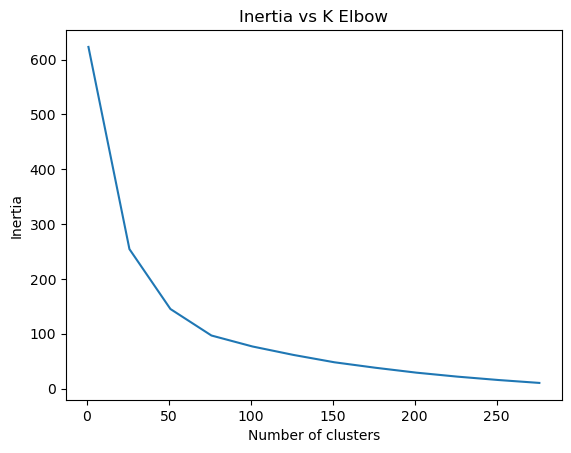

In [53]:
# Let's map the inertia for different number of clusters to find the optimal number of clusters
# We'll plot it to see the elbow
inertia = []
clusters = 300
step = 25
max_iter = 50
n_init = 5
random_state = 42

for k in range(1, clusters, step):
    kmeans = KMeans(
        n_clusters=k,
        max_iter=max_iter,
        n_init=n_init,
        random_state=random_state,
    ).fit(X_lsa)
    inertia.append(kmeans.inertia_) ## Summing square distance to nearest cluster

ks = list(range(1, clusters, step))
plt.plot(ks, inertia)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')                    # Intertia label for y axis
plt.title('Inertia vs K Elbow')  # Graph title
plt.show()                               # display


There appears to be an elbow about 50, so we'll use 50 clusters.

In [55]:

n_clusters = 50  

kmeans = KMeans(
    n_clusters=n_clusters,
    max_iter=max_iter,
    n_init=n_init,
    random_state=random_state
).fit(X_lsa)


In [56]:
# First up, we zip the unique article IDs with their KMeans labels into a simple dict. Easy.
article_cluster_map = dict(
    zip(
        df_unique_articles['article_id'],
        kmeans.labels_
    )
)

# And then we slap those cluster labels right onto our main DataFrame.
# Each article_id gets looked up, and voilà—title_cluster is born.
df['title_cluster'] = df['article_id'].map(article_cluster_map)


In [57]:
# Let's check the number of articles in each cluster
np.array(np.unique(kmeans.labels_, return_counts=True)).T

array([[ 0, 23],
       [ 1, 14],
       [ 2,  2],
       [ 3, 65],
       [ 4, 10],
       [ 5, 19],
       [ 6, 42],
       [ 7, 14],
       [ 8, 21],
       [ 9, 20],
       [10, 31],
       [11, 27],
       [12, 37],
       [13, 14],
       [14, 15],
       [15, 10],
       [16,  9],
       [17,  6],
       [18, 18],
       [19, 12],
       [20, 10],
       [21,  8],
       [22, 11],
       [23, 16],
       [24, 12],
       [25, 13],
       [26,  7],
       [27,  1],
       [28,  8],
       [29,  5],
       [30,  8],
       [31,  8],
       [32, 14],
       [33, 18],
       [34, 10],
       [35, 16],
       [36, 23],
       [37,  8],
       [38,  5],
       [39, 14],
       [40,  4],
       [41,  6],
       [42,  6],
       [43, 20],
       [44, 11],
       [45, 12],
       [46,  8],
       [47,  7],
       [48, 10],
       [49,  6]])

In [58]:
def get_similar_articles(article_id, df=df):
    """
    INPUT:
    article_id - (int) an article id 
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    article_ids - (list) a list of article ids that are in the same title cluster
    
    Description:
    Returns a list of the article ids that are in the same title cluster
    """
    # snag the cluster label for our article of interest.
    title_cluster = df.loc[df['article_id'] == article_id, 'title_cluster'].iloc[0]
    
    # get every article in same cluster
    articles_in_cluster = df.loc[df['title_cluster'] == title_cluster, 'article_id'] \
                             .drop_duplicates() \
                             .tolist()
    
    # kick out the original article from our list
    articles_in_cluster = [aid for aid in articles_in_cluster if aid != article_id]
    
    return articles_in_cluster

In [59]:
def make_content_recs(article_id, n, df=df):
    """
    INPUT:
    article_id - (int) an article id
    n - (int) the number of recommendations you want similar to the article id
    df - (pandas dataframe) df as defined at the top of the notebook

    OUTPUT:
    n_ranked_similar_articles - (list) a list of article ids that are in the same title cluster ranked
                                by popularity
    n_ranked_article_names - (list) a list of article names associated with the list of article ids

    Description:
    Returns a list of the n most ranked similar articles to a given article_id based on the title
    cluster in df. Rank similar articles using the function get_ranked_article_unique_counts.
    """
    # First, let’s grab all the article IDs hanging out in the same cluster.
    similar_ids = get_similar_articles(article_id, df=df)
    
    # And next, we’ll rank those IDs by how many unique readers they’ve got.
    ranked_similar = get_ranked_article_unique_counts(similar_ids, user_item=user_item)
    
    # Now we pull off just the top‑n article IDs for our rec list.
    n_ranked_similar_articles = [art_id for art_id, _ in ranked_similar[:n]]
    
    # Then fetch each title so you’ve got names, not just IDs.
    n_ranked_article_names = get_article_names(n_ranked_similar_articles, df=df)
    
    return n_ranked_similar_articles, n_ranked_article_names

In [60]:
# Test out your content recommendations given artice_id 25
rec_article_ids, rec_article_titles = make_content_recs(25, 10)
print(rec_article_ids)
print(rec_article_titles)

[1025, 237, 593, 349, 821, 464, 29, 1042, 693, 48]
['experience iot with coursera', 'data science experience documentation', 'deep learning with data science experience', 'ibm data science experience white paper - sparkr transforming r into a tool for big data analytics', 'use ibm data science experience to detect time series anomalies', 'upload files to ibm data science experience using the command line', 'better together: spss and data science experience', 'using rstudio in ibm data science experience', 'data tidying in data science experience', 'use ibm data science experience to read and write data stored on amazon s3']


In [61]:
assert len({1025, 593, 349, 821, 464, 29, 1042, 693, 524, 352}.intersection(set(rec_article_ids))) > 0, "Oops! Your the make_content_recs function doesn't work quite how we expect."

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function? What other text data would be useful to help make better recommendations besides the article title?

## How the Content‑Based Recommender Works

**Title with TF‑IDF Vectors**  
We start by turning each article’s title into a numerical fingerprint. TF‑IDF highlights the words that really matter and downplays the filler.

**Dimensionality Reduction with LSA**  
Next, we run Truncated SVD (LSA) on those TF‑IDF vectors and normalize the result. This squeezes our high‑dimensional data down to its most important themes—while keeping things comparable.

**Clustering via K‑Means**  
Armed with those compressed features, we group articles into clusters. Each cluster gathers titles that “talk” about similar topics.

**Finding and Ranking Similar Items**  
When you give me an article ID, I look up its cluster, pull all other IDs in that bucket, and then rank them by pure popularity (unique user interactions). The top _n_ become your content‑based recommendations.

## Possible Improvements

**Beyond Just Titles**  
And honestly, titles are pretty short. We could enrich our vectors with article abstracts, full text, or even tags and keywords.

**Smarter Text Embeddings**  
But word counts only go so far. Switching to Word2Vec, GloVe, or BERT embeddings would capture deeper semantic meaning, not just raw frequency.

**Dynamic or Hierarchical Clustering**  
K‑Means forces equal‑sized clusters. Trying DBSCAN or hierarchical methods might reveal more natural groupings.

**Hybrid Blends**  
Mixing in collaborative filtering so you factor in both content and user behavior often yields even better recs.

## Other Data That Could Be Useful

**Publication Metadata**  
Things like publication date, author info, or category labels would help filter stale content or highlight trusted writers.

**User Feedback Signals**  
Star ratings, likes, or even how long someone hangs out on a page can refine which similar articles truly resonate.

**Rich Media Features**  
If we had images, video transcripts, or social tags, we could extract multimodal features for even richer similarity.

All in all, our simple title‑based pipeline works surprisingly well. But there’s always room to experiment and make it smarter!


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to users.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [65]:
# quick look at the matrix
user_item.head()

article_id,0,2,4,8,9,12,14,15,16,18,...,1434,1435,1436,1437,1439,1440,1441,1442,1443,1444
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


`2.` In this situation, you can use Singular Value Decomposition from [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) on the user-item matrix.  Use the cell to perform SVD.

In [67]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import precision_score, recall_score, accuracy_score
# Using the full number of components which equals the number of columns
svd = TruncatedSVD(n_components=len(user_item.columns), n_iter=5, random_state=42)

u = svd.fit_transform(user_item)
v = svd.components_
s = svd.singular_values_ 
print('u', u.shape)
print('s', s.shape)
print('vt', v.shape)

u (5149, 714)
s (714,)
vt (714, 714)


`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain better metrics when making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how our metrics improve as we increase the number of latent features.

Text(0.5, 1.0, 'Metrics vs. Number of Latent Features')

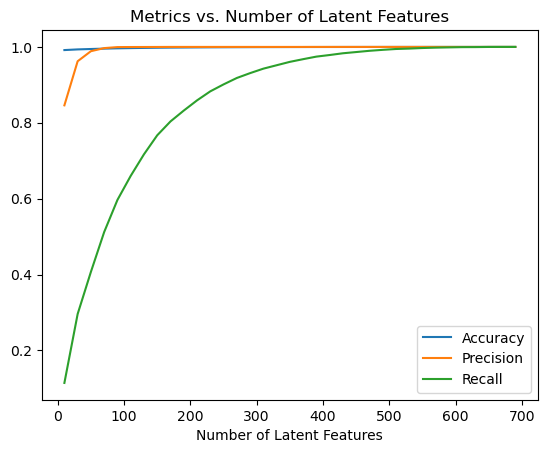

In [70]:
num_latent_feats = np.arange(10, 700+10, 20)
metric_scores = []

for k in num_latent_feats:
    # restructure with k latent features
    u_new, vt_new = u[:, :k], v[:k, :]
    
    # take dot product
    user_item_est = abs(np.around(np.dot(u_new, vt_new))).astype(int)
    # make sure the values are between 0 and 1
    user_item_est = np.clip(user_item_est, 0, 1)
    
    # total errors and keep track of them
    acc = accuracy_score(user_item.values.flatten(), user_item_est.flatten())
    precision = precision_score(user_item.values.flatten(), user_item_est.flatten())
    recall = recall_score(user_item.values.flatten(), user_item_est.flatten())
    metric_scores.append([acc, precision, recall])
    
    
plt.plot(num_latent_feats, metric_scores, label=['Accuracy', 'Precision', 'Recall'])
plt.legend()
plt.xlabel('Number of Latent Features')
plt.title('Metrics vs. Number of Latent Features')

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations. Given the plot above, what would you pick for the number of latent features and why?

**Optimal Latent Feature Choice**

At around 200 dimensions our accuracy and precision curves have already hit their stride, so we’re effectively nailing the true positives and avoiding false alarms. However, after about 200, recall gains start to taper off, meaning extra features just bulk up the model without moving the needle much. Since we care about keeping things lean and sidestepping overfitting, settling on 200 latent features feels right and is a balanced sweet spot between performance and simplicity.

`5.` Using 200 latent features and the values of U, S, and V transpose we calculated above, create an article id recommendation function that finds similar article ids to the one provide.

Create a list of 10 recommendations that are similar to article with id 4.  The function should provide these recommendations by finding articles that have the most similar latent features as the provided article.

In [74]:
def get_svd_similar_article_ids(article_id, vt, user_item=user_item, include_similarity=False):
    """
    INPUT:
    article_id - (int) an article id
    vt - (numpy array) vt matrix from SVD
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    include_similarity - (bool) whether to include the similarity in the output
    
    OUTPUT:
    article_ids - (list) a list of article ids that are in the same title cluster
    
    Description:
    Returns a list of the article ids similar using SVD factorization
    """
    # And first up, let’s figure out where this article ID sits in our columns
    article_idx = user_item.columns.get_loc(article_id)
    
    # Then we compute cosine similarity across every article feature vector...
    cos_sim = cosine_similarity(vt.T)
    
    # Next, grab the row of sims that corresponds to our target article
    article_similarities = cos_sim[article_idx]
    
    # Now we sort them in descending order—just remember to drop the article itself
    similar_indices = article_similarities.argsort()[::-1]
    similar_indices = [i for i in similar_indices if i != article_idx]
    
    # And here we build our list pairing each index to its ID and score
    most_similar_items = [
        (int(user_item.columns[i]), article_similarities[i])
        for i in similar_indices
    ]
    
    # Finally, return either the full pairs or just the IDs, up to 10
    if include_similarity:
        return most_similar_items[:10]
    return [aid for aid, _ in most_similar_items[:10]]


In [75]:
# Create a vt_new matrix with 200 latent features
k = 200
vt_new = v[:k, :]

In [76]:
# What is the article name for article_id 4?
print("Current article:", get_article_names([4], df=df)[0])

Current article: analyze ny restaurant data using spark in dsx


In [77]:
# What are the top 10 most similar articles to article_id 4?
rec_articles = get_svd_similar_article_ids(4, vt_new, user_item=user_item)[:10]
rec_articles

[1199, 1068, 486, 1202, 176, 1120, 244, 793, 58, 132]

In [78]:
# What are the top 10 most similar articles to article_id 4?
get_article_names(rec_articles, df=df)

['advancements in the spark community',
 'collecting data science cheat sheets',
 'top analytics tools in 2016',
 'notebooks: a power tool for data scientists',
 'use spark r to load and analyze data',
 '10 powerful features on watson data platform, no coding necessary',
 'airbnb data for analytics: athens reviews',
 'airbnb data for analytics: paris calendar',
 'country statistics: crude oil - exports',
 'country statistics: crude oil - proved reserves']

In [79]:
assert set(rec_articles) == {1199, 1068, 486, 1202, 176, 1120, 244, 793, 58, 132}, "Oops! Your the get_svd_similar_article_ids function doesn't work quite how we expect."
print("That's right!  Great job!")

That's right!  Great job!


`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make above are an improvement to how users currently find articles, either by Sections 2, 3, or 4? Add any tradeoffs between each of the methods, and how you could leverage each type for different situations including new users with no history, recently new users with little history, and users with a lot of history. 

## Measuring Recommendation Improvement

Thinking about how to tell if our new suggestions actually help users find interesting articles, we’d start by gathering some data. One low‑barrier approach is to run A/B tests: split users into groups and show one group the old **Section 2: rank‑based** recommendations, another group the **Section 3: collaborative** picks, and a third group the **Section 4: content‑based** recs. Then track engagement metrics—click‑through rates, time spent reading, or even whether they come back for more. And sure, it takes a bit of engineering to route traffic, but you’d quickly see which method nudges people to click more or explore deeper.

If you can’t do a full A/B experiment yet, compare some offline metrics. For example, hold out a slice of historical interactions and see how well each method predicts held‑out clicks (precision, recall, or ranking metrics like NDCG). That gives you a rough idea of which algorithm is catching user interests best before deploying anything live.

---

## Tradeoffs Among Methods

**Section 2 (Popularity, Rank‑Based)** shines because it’s super simple. Even brand‑new users get “most popular” recs, which usually work okay as a fallback. But it’s one‑size‑fits‑all, and that heavy bias toward the same top articles means niche or emerging content never gets exposure.

**Section 3 (Collaborative Filtering)** personalizes based on users who read similar things. Once a user has history, this often surfaces hidden gems they wouldn’t find via “most popular.” Yet it requires a decent amount of reading history. If someone’s new or only skimmed a couple of articles, the recommendations can be noisy or sparse.

**Section 4 (Content‑Based)** doesn’t rely on user history at all—just looks at article similarities. It’s great for recommending “more like this” once you know a single liked article. The downside is that it’s limited by title text; if titles are short or generic, the clusters can be off. Also, it doesn’t capture what the community actually enjoys since there are no user signals.

---

## Who Should Get What?

For brand‑new users with zero history, roll out the **rank‑based recs (Section 2)**. At least they’ll see the “hottest” articles and won’t feel lost. If someone has barely any history—say two to five clicks—mix in **content‑based recs (Section 4)**. If they liked one article, suggest others with similar titles, but also show a few popular picks so they don’t miss crowd favorites. Heavy history users (50+ clicks) should have **collaborative filtering (Section 3)** take the wheel. You’ve mined enough data to say, “Here’s what people like you usually enjoy next.” You can still sprinkle in content‑based or popular recs for diversity.

---

## Final Thoughts

And at the end of the day, blending these methods often works best—one algorithm alone rarely fits every scenario. By monitoring engagement and iterating, you’ll learn which mix keeps users clicking, exploring, and ultimately coming back for more.


<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendation Systems project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 